## Convolutional Re-parameterization

In [10]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision

kernel = torch.randn(5, 10, 3, 3) # 16x3x3 32개 
gamma = torch.randn(1, 5, 1, 1)

x = torch.randn(1, 10, 5, 5) # batch 하나만 고려 

y = F.conv2d(x, kernel, padding = 1) * gamma # y는 conv통과한 feature map에 gamma를 곱한다

kernel_reparam = kernel * gamma.reshape(-1, 1, 1, 1)
y_reparam = F.conv2d(x, kernel_reparam, padding = 1)
torch.allclose(y, y_reparam, atol = 1e-5)

True

## BN fusion(Conv + BN)

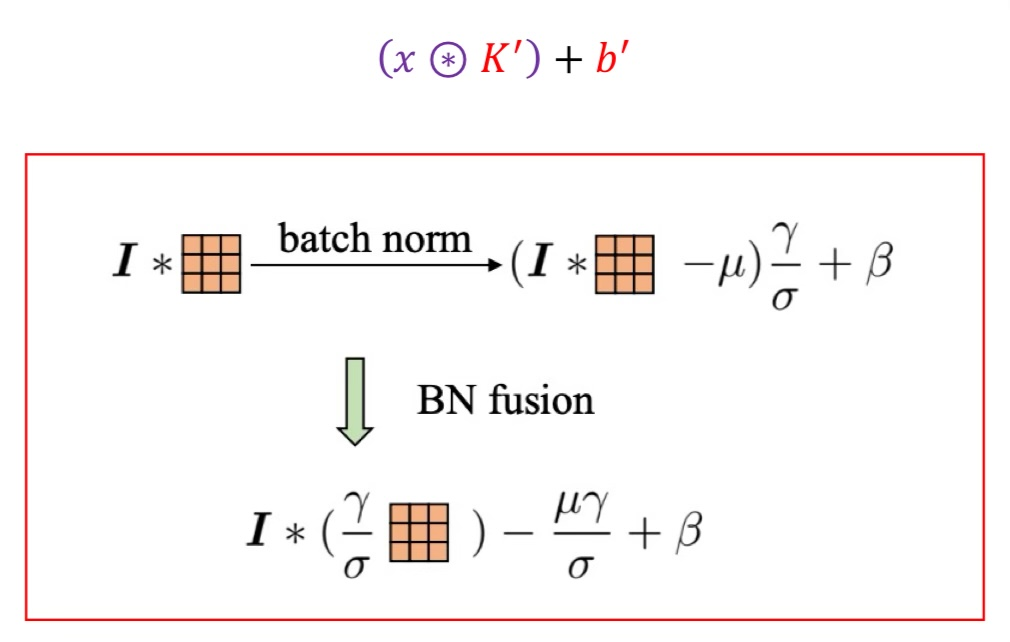

In [13]:
@torch.no_grad() # 아래 함수가 실행될 때 기울기 계산을 비활성화.
def merge_convBN_to_conv(sequental: nn.Sequential): # colon의 의미? 파라미터, "sequental"은 nn.Sequential 타입이어야 한다.
    # conv의 param
    kernel = sequental[0].weight # 다음 코드 셀에서 Sequential의 0번째가 conv임
    # BN의 param
    mu = sequental[1].running_mean # Sequential의 1번째가 BN임
    var = sequental[1].running_var
    eps = sequental[1].eps # 분모 0 방지용
    gamma = sequental[1].weight
    beta = sequental[1].bias

    sigma = torch.sqrt(var+eps)
    kernel__reparam = kernel * ((gamma / sigma).reshape(-1, 1, 1, 1))
    bias__reparam = beta - mu * gamma / sigma

    return kernel__reparam, bias__reparam

In [14]:
# Confusion 적용 안된 conv + BN
x = torch.randn(1, 16, 32, 32)
convbn = nn.Sequential(
    nn.Conv2d(16, 32, 3, padding = 1, bias = False), # in_channel, out_channel(커널 개수), kernel_size
    nn.BatchNorm2d(32, track_running_stats = False)
).eval()

convbn[1].running_mean = torch.zeros(32) # 일단 암거나 넣기
convbn[1].running_var = torch.ones(32)

y = convbn(x)

# Confusion BN 
kernel__reparam, bias__reparam = merge_convBN_to_conv(convbn) # 위 코드 셀에 있던 함수임

conv = nn.Conv2d(16, 32, 3, padding = 1) # 하나의 conv만을 쓸 건데 파라미터만 바꿔준다(BN이 적용되도록) 
conv.weight = nn.Parameter(kernel__reparam)
conv.bias = nn.Parameter(bias__reparam)

y__reparam = conv(x)

# 똑같을까?
torch.allclose(y, y__reparam, atol = 1e-5)

True

## Parallel Convolutions(branch fusion)

In [34]:
@torch.no_grad()
def intergrate_parallel_convolutions(*conv_layers, max_kernel_size): # * : 나중에 함수의 입력을 받을 때 튜플처리한다. # e.g., intergrate_parallel_convolutions(conv1, conv2, conv3, max_kernel_size = 3) 이렇게 하면 conv1~conv3이 튜플처리 된다.
    kernel_reparam = 0. #초기화
    bias_reparam = 0.
    for conv_layer in conv_layers: #튜플로 받으니께
        kernel, bias = conv_layer.weight, conv_layer.bias
        pad_h = (max_kernel_size - kernel.shape[2]) // 2
        pad_w = (max_kernel_size - kernel.shape[3]) // 2

        kernel = F.pad(kernel, (pad_w, pad_w, pad_h, pad_h)) # 아래 그림 참조
        kernel_reparam += kernel
        bias_reparam += bias

    return kernel_reparam, bias_reparam

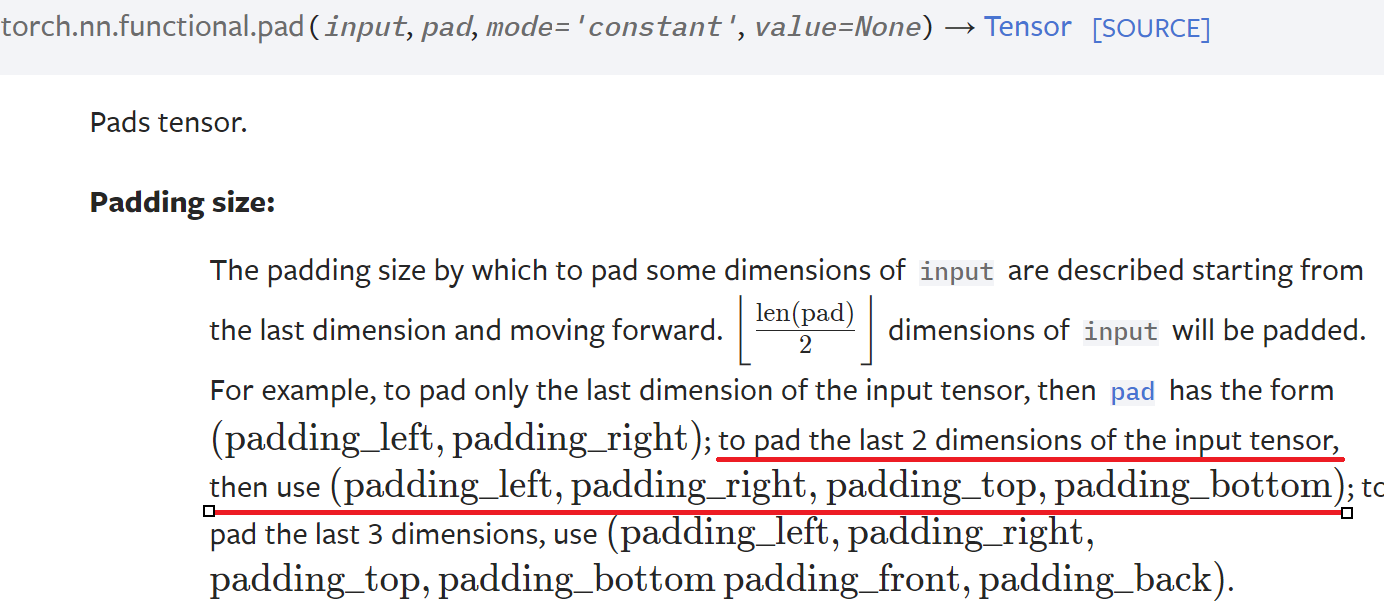

In [25]:
conv1 = nn.Conv2d(16, 32, 3, padding=1)
conv2 = nn.Conv2d(16, 32, (3,1), padding = (1,0))
conv3 = nn.Conv2d(16, 32, (1,3), padding = (0,1))
print(conv1.weight.shape)
print(conv2.weight.shape)
print(conv3.weight.shape)

torch.Size([32, 16, 3, 3])
torch.Size([32, 16, 3, 1])
torch.Size([32, 16, 1, 3])


In [36]:
# 3개를 parallel하는 원래 방법
x = torch.randn(1, 16, 32, 32)

conv1 = nn.Conv2d(16, 32, 3, padding = 1)
conv2 = nn.Conv2d(16, 32, (3,1), padding = (1,0))
conv3 = nn.Conv2d(16, 32, (1,3), padding = (0,1))

y = conv1(x) + conv2(x) + conv3(x)

# branch fusion
kernel, bias = intergrate_parallel_convolutions(conv1, conv2, conv3, max_kernel_size = 3)
conv = nn.Conv2d(16, 32, 3, padding = 1) # 젤 큰놈으로 하나 생성
conv.weight = nn.Parameter(kernel)
conv.bias = nn.Parameter(bias)

y_reparam = conv(x)

torch.allclose(y, y_reparam, atol = 1e-5)

True

## Identity skip

In [1]:
import numpy as np

In [ ]:
def get_identity_kernel(channel):
    id_value = np.zeros((channel, channel, 1, 1)) # 모든 가중치를 일단 0으로 초기화
    for i in range(channel):
        id_value[i,i,0,0] = 1 # 입력 채널 순번과 커널의 순번이 같을 때, 가중치를 1로 설정. 나머지는 0이다.
    return torch.from_numpy(id_value).float()

x = torch.randn(1, 16, 32, 32)
y = x.clone()

kernel = get_identity_kernel(16)
conv = nn.Conv2d(16, 16, 1, bias = False)
conv.weight = nn.Parameter(kernel)

y_reparam = conv(x)

torch.allclose(y, y__reparam, atol = 1e-3)